In [1]:
from keras_facenet import FaceNet
import numpy as np
import os

import matplotlib.pyplot as plt
import cv2 

# check if there is a GPU available
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


2023-01-27 14:53:17.671304: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-27 14:53:17.759825: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-27 14:53:18.224200: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/theshadow/miniconda3/envs/si-cctv/lib/python3.10/site-packages/cv2/../../lib64::/

Num GPUs Available:  1


2023-01-27 14:53:19.012364: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-27 14:53:19.016427: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-27 14:53:19.016558: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [9]:
"""
idea per il training

Embeddings path: ./LFW/embeddings

Estraiamo gli embeddings, li salviamo in un file e li usiamo per il training in un secondo momento.
Il nostro classificatore sarà un classificatore binario, che confronterà due embeddings e dirà se fanno parte della stessa persona.

Faccia1 -> FaceNet - 
                    | 
                    -> Training di un classificatore binario -> 0/1
                    |
Faccia2 -> FaceNet -

Come strutturare il trainig?

1) Col dataset che abbiamo costruito nell'altro notebook, manteniamo la struttura, salviamo gli embeddings e salviamo il tutto dentro un file .npy (così da evitare di dover fare sempre la stessa computazione)
2) Con un ciclo for in range(mini batch), facciamo la fit del classificatore binario. Come loss function usiamo la cross entropy, come ottimizzatore usiamo l'adam.


"""

"\nidea per il training\n\nEmbeddings path: ./LFW/embeddings\n\nEstraiamo gli embeddings, li salviamo in un file e li usiamo per il training in un secondo momento.\nIl nostro classificatore sarà un classificatore binario, che confronterà due embeddings e dirà se fanno parte della stessa persona.\n\nFaccia1 -> FaceNet - \n                    | \n                    -> Training di un classificatore binario -> 0/1\n                    |\nFaccia2 -> FaceNet -\n\nCome strutturare il trainig?\n\n1) Col dataset che abbiamo costruito nell'altro notebook, manteniamo la struttura, salviamo gli embeddings e salviamo il tutto dentro un file .npy (così da evitare di dover fare sempre la stessa computazione)\n2) Con un ciclo for in range(mini batch), facciamo la fit del classificatore binario. Come loss function usiamo la cross entropy, come ottimizzatore usiamo l'adam.\n\n\n"

2023-01-27 14:53:21.487631: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-27 14:53:21.488285: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-27 14:53:21.488434: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-27 14:53:21.488510: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there

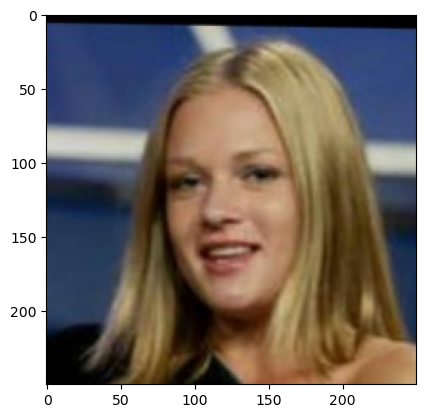

(250, 250, 3)


In [2]:
embedder = FaceNet()

path = "./LFW/lfw_funneled/AJ_Cook/AJ_Cook_0001.jpg" #this is the image
image = cv2.imread(path)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


plt.imshow(image)
plt.show()

#print the shape of the image
print(image.shape)

1/1 [==============================] - 0s 28ms/step
[-0.01273254 -0.03548829 -0.05412503 -0.02833573  0.00838593 -0.00087699
  0.00054658  0.07850153 -0.07725959  0.07699814 -0.00399624  0.0572665
 -0.03576722 -0.00060287 -0.03485071 -0.01752095 -0.05394479 -0.00399545
 -0.03523308  0.04503918  0.02839556 -0.00507381  0.01300929 -0.06235723
 -0.0228074   0.02644825  0.04746445  0.03777048  0.05246732 -0.00069184
  0.04815437 -0.01276517 -0.00528578 -0.0102943  -0.00131115 -0.06813154
 -0.05870292 -0.00518278 -0.0244622  -0.02039478 -0.02346925  0.00847829
 -0.03996375  0.07781906  0.00024051 -0.08790819 -0.02422723  0.02092984
 -0.02467373 -0.0067543  -0.14625603 -0.07268774  0.12814018  0.01476686
 -0.00036878  0.0875571  -0.06634944  0.09674188 -0.00562549 -0.00463078
  0.06886791  0.02176864 -0.01277864  0.0593881   0.05102346 -0.01558343
  0.01126813 -0.06385117 -0.01897507 -0.00357165 -0.08009935 -0.02967138
  0.04107303  0.00243685 -0.07329093  0.06604702 -0.00225318 -0.0731387
 

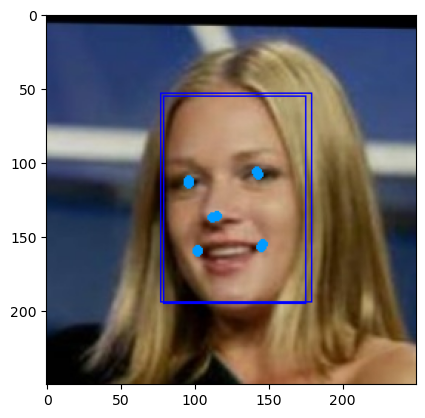

: 

In [5]:


detections = embedder.extract(image, threshold=0.95)
#print the shape of image


print(detections[0]['embedding'])
print(len(detections[0]['embedding']))


print(detections)       #for every detected face, it returns a dict with the bounding box, keypoints and the embedding

#draw the bounding box and the keypoints
for detection in detections:
    
    #boxCoordinates 
    box = detection['box']
    x1, y1, width, height = box
    x2, y2 = x1 + width, y1 + height

    #keypoints
    keypoints = detection['keypoints']
    left_eye, right_eye, nose, mouth_left, mouth_right = keypoints['left_eye'], keypoints['right_eye'], keypoints['nose'], keypoints['mouth_left'], keypoints['mouth_right']

    #draw the bounding box
    cv2.rectangle(image, (x1, y1), (x2, y2), (0,0,255), 1)

    #draw the keypoints
    cv2.circle(image, left_eye, 2, (0,155,255), 2)
    cv2.circle(image, right_eye, 2, (0,155,255), 2)
    cv2.circle(image, nose, 2, (0,155,255), 2)
    cv2.circle(image, mouth_left, 2, (0,155,255), 2)
    cv2.circle(image, mouth_right, 2, (0,155,255), 2)

plt.imshow(image)
plt.show()

In [ ]:
embeddings = embedder.embeddings([image])       #già cropped.
print(embeddings)